<h1> <font color=black> Deep Learning with Python (DLPy) and SAS Viya for Computer Vision </h1>
<h1> <font color=black> Multitask Deep Learning For Image Tagging </h1>

![alt text](Ctype.png "Title")

![alt text](ColorCapture.png "Title")

## Introduction to Multitask Learning
-  Multitask Learning :  joint learning, learning to learn, and learning with auxiliary tasks.
Multitask learning is a learning paradigm that aims to leverage useful information in multiple RELATED tasks to help improve overall generalization.  These models can be simpler to deploy and manage because you have just one model for all tasks. 


![alt text](CCapture.png "Title")

##  Applications

-  Applications: natural language processing, autonomous cars, fashion, etc.

<div class="alert alert-warning">
<b> LIBRARIES, CAS, AND ACTION SETS</b>
</div>

In [25]:
from swat import *
from pprint import pprint

%matplotlib inline
import matplotlib
import sys

sys.path.append('C:\\dlpy\\python-dlpy')
from dlpy import Model, Sequential
from dlpy.layers import *
from dlpy.applications import *
from dlpy.utils import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split

from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import Image

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.misc import imresize
import swat


In [ ]:
# CAS Connection
conn = swat.CAS('CASserver',port)

In [28]:
conn = swat.CAS('xyz.unx.sas.com', 33366)

In [29]:
conn.loadactionset('Image')
conn.loadactionset('deepLearn')
conn.loadactionset('astore')
conn.loadactionset('sampling');

NOTE: Added action set 'Image'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'sampling'.


In [30]:
# Setup a CAS Library
conn.addcaslib(activeonadd=True,
                     datasource={'srctype':'path'},
                     name='retaildata',
                     path='/cas/DeepLearn/sasrwt/',
                     subdirectories=True);

NOTE: 'retaildata' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'retaildata'.


<div class="alert alert-warning">
<b>LOAD AND PREVIEW DATA</b>
</div>

In [31]:
conn.loadimages(path='retailMultiLabel',
                casout=dict(name='retail_data', replace=True),
                caslib='retaildata',
                labellevels=-1, # Pull Subdirectories as Labels
                recurse=True)

NOTE: Loaded 2167 images from /cas/DeepLearn/sasrwt/retailMultiLabel into Cloud Analytic Services table retail_data.


,casLib,Name,Rows,Columns,casTable
0,retaildata,retail_data,2167,6,"CASTable('retail_data', caslib='retaildata')"


In [32]:
conn.CASTable('retail_data').head()

,_image_,_size_,_path_,_label_,_type_,_id_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,244278,/cas/DeepLearn/sasrwt/retailMultiLabel/red_dre...,red_dress,jpg,1
1,b'\xff\xd8\xff\xe1\x1a\x08Exif\x00\x00MM\x00*\...,146577,/cas/DeepLearn/sasrwt/retailMultiLabel/red_dre...,red_dress,jpg,2
2,b'\xff\xd8\xff\xe1\x10\x04Exif\x00\x00II*\x00\...,136929,/cas/DeepLearn/sasrwt/retailMultiLabel/red_dre...,red_dress,jpg,3
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,126668,/cas/DeepLearn/sasrwt/retailMultiLabel/red_dre...,red_dress,jpg,4
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,179679,/cas/DeepLearn/sasrwt/retailMultiLabel/red_dre...,red_dress,jpg,5


In [33]:
#  Frequency Images
conn.CASTable('retail_data').freq(inputs='_label_')

,Column,CharVar,FmtVar,Level,Frequency
0,_label_,black_jeans,black_jeans,1,344.0
1,_label_,blue_dress,blue_dress,2,386.0
2,_label_,blue_jeans,blue_jeans,3,356.0
3,_label_,blue_shirt,blue_shirt,4,369.0
4,_label_,red_dress,red_dress,5,380.0
5,_label_,red_shirt,red_shirt,6,332.0


<div class="alert alert-warning">
<b>DATA PREPARATION FOR MULTIPLE LABELS</b>
</div>

In [34]:
retail_data = conn.CASTable('retail_data')

In [35]:
# Create Dummies Table from _label_ Column
# Convert categorical variable into dummy/indicator variables

dummy = pd.get_dummies(retail_data['_label_'])

# Preview
dummy.head()

,black_jeans,blue_dress,blue_jeans,blue_shirt,red_dress,red_shirt
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0


In [36]:
#generate binary labels using SAS Function Compiler
retail_data = conn.CASTable('retail_data', 
                            computedVars=['black','blue','red','jeans','dress','shirt','denim','cotton_blend','women'],
                            computedVarsProgram='black=0; blue=0; red=0; jeans=0; \
                            dress=0; shirt=0; denim=0; cotton_blend=0;  women=0; \
                            if (_label_ = "black_jeans") then do; black=1; jeans=1; denim=1; end; \
                            if (_label_ = "blue_dress") then do; blue=1; dress=1; women=1; cotton_blend=1; end; \
                            if (_label_ = "blue_jeans") then do; blue=1; jeans=1; denim=1; end; \
                            if (_label_ = "blue_shirt") then do; blue=1; shirt=1; cotton_blend=1; end; \
                            if (_label_ = "red_dress") then do; red=1; dress=1; women=1; cotton_blend=1; end; \
                            if (_label_ = "red_shirt") then do; red=1; shirt=1; cotton_blend=1; end; \
                            ')

conn.partition(table=retail_data, 
             casout=dict(name='retail_data_joined', replace=True))


[averageShuffleWaitTime]

 0

[caslib]

 'retaildata'

[maxShuffleWaitTime]

 0

[minShuffleWaitTime]

 1e+300

[rowsTransferred]

 0

[shuffleWaitTime]

 0

[tableName]

 'RETAIL_DATA_JOINED'

[casTable]

 CASTable('RETAIL_DATA_JOINED', caslib='retaildata')

+ Elapsed: 0.228s, user: 0.788s, sys: 1.05s, mem: 626mb

In [37]:
# Preview
conn.CASTable('retail_data_joined').head()

,_image_,_size_,_path_,_label_,_type_,_id_,black,blue,red,jeans,dress,shirt,denim,cotton_blend,women
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,344723,/cas/DeepLearn/sasrwt/retailMultiLabel/blue_dr...,blue_dress,jpg,1172,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,89953,/cas/DeepLearn/sasrwt/retailMultiLabel/blue_dr...,blue_dress,jpg,1173,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,291227,/cas/DeepLearn/sasrwt/retailMultiLabel/blue_dr...,blue_dress,jpg,1174,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,98804,/cas/DeepLearn/sasrwt/retailMultiLabel/blue_dr...,blue_dress,jpg,1175,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,59015,/cas/DeepLearn/sasrwt/retailMultiLabel/blue_dr...,blue_dress,jpg,1176,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [38]:

conn.CASTable('retail_data_joined').freq(inputs='_label_')

,Column,CharVar,FmtVar,Level,Frequency
0,_label_,black_jeans,black_jeans,1,344.0
1,_label_,blue_dress,blue_dress,2,386.0
2,_label_,blue_jeans,blue_jeans,3,356.0
3,_label_,blue_shirt,blue_shirt,4,369.0
4,_label_,red_dress,red_dress,5,380.0
5,_label_,red_shirt,red_shirt,6,332.0


In [39]:
retail_data_dlpy = ImageTable.from_table(conn.CASTable('retail_data_joined'),
                                              image_col='_image_',
                                              label_col='_label_')


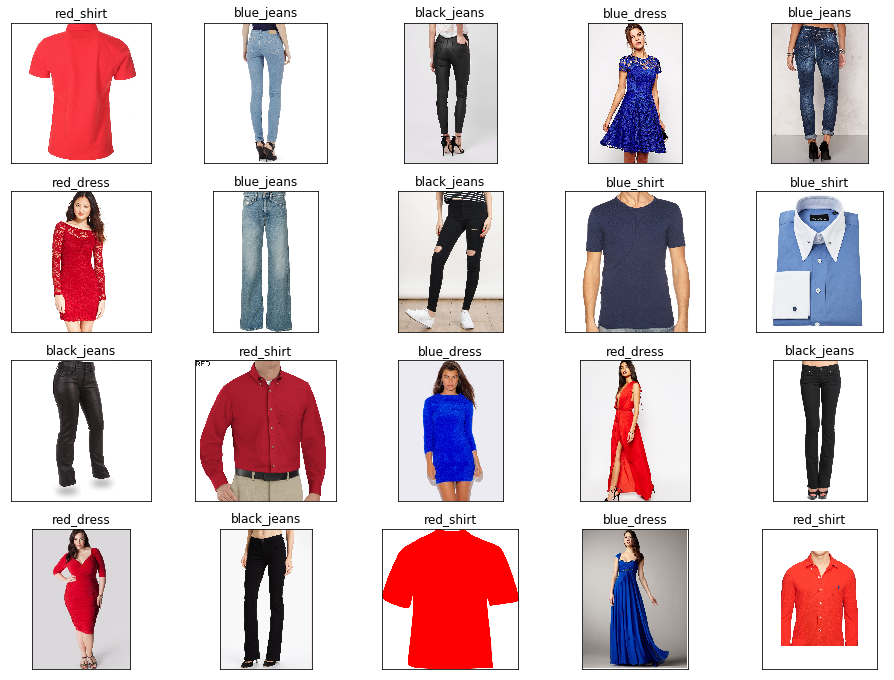

In [40]:
# Preview Images
retail_data_dlpy.show(nimages=20, ncol=5, randomize=True)

In [41]:
# Resize Images to 200 x 200 and Copy Variables Over
conn.image.processimages(imagetable='retail_data_joined',
                         casout=dict(name='retail_data_resized', replace=True),
                         imagefunctions=[dict(functionoptions=dict(functiontype='resize', w=200, h=200))],
                         copyVars=['black','blue','red','jeans','dress','shirt','denim','cotton_blend','women']
                        )

NOTE: Table RETAIL_DATA_JOINED contains compressed images.
NOTE: 2165 out of 2167 images were processed successfully and saved as compressed images to the Cloud Analytic Services table retail_data_resized.


,casLib,Name,Rows,Columns,casTable
0,retaildata,retail_data_resized,2165,15,"CASTable('retail_data_resized', caslib='retail..."


In [42]:
# Shuffle Data
retail_data_resized = conn.CASTable('retail_data_resized')

retail_data_resized.shuffle(casout=dict(name='retail_data_shuffled', replace=True, blockSize=64));

In [43]:
# Split Training Data into Train / Test
trainData, testData = two_way_split(retail_data_resized, test_rate=20, seed=12345)

In [44]:
# Random Sample for Partition Variable
conn.srs(table=dict(name='retail_data_shuffled'),
         partind=True,
         sampPct=20,
         output=dict(casout=dict(name='retail_data_final', replace=True),
                     copyVars='ALL'));

NOTE: Using SEED=231630960 for sampling.


In [45]:
# Preview
conn.CASTable('retail_data_final').head()

,black,blue,red,jeans,dress,shirt,denim,cotton_blend,women,_image_,_size_,_path_,_type_,_id_,_label_,_PartInd_
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,6480,/cas/DeepLearn/sasrwt/retailMultiLabel/black_j...,jpg,1803,black_jeans,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,9959,/cas/DeepLearn/sasrwt/retailMultiLabel/red_shi...,jpg,802,red_shirt,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,9890,/cas/DeepLearn/sasrwt/retailMultiLabel/red_dre...,jpg,305,red_dress,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2945,/cas/DeepLearn/sasrwt/retailMultiLabel/blue_sh...,png,464,blue_shirt,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,7213,/cas/DeepLearn/sasrwt/retailMultiLabel/red_shi...,jpg,873,red_shirt,0.0


<div class="alert alert-warning">
<b>CREATE MULTI TASK MODEL</b>
</div>

In [46]:
inp = Input(3, 200, 200, offsets=retail_data_dlpy.channel_means, name='data')
conv1 = Conv2d(64, 3, include_bias=False, act='identity')(inp)
bn1 = BN(act='relu')(conv1)
pool1 = Pooling(2)(bn1)
conv2 = Conv2d(64, 3,include_bias=False, act='identity')(pool1)
bn2 = BN(act='relu')(conv2)
pool2 = Pooling(2)(bn2)
dense1 = Dense(512)(pool2)
output1 = OutputLayer(n=1, act='sigmoid', error='entropy', name='output1')(dense1)
output2 = OutputLayer(n=1, act='sigmoid', error='entropy', name='output2')(dense1)
output3 = OutputLayer(n=1, act='sigmoid', error='entropy', name='output3')(dense1)
output4 = OutputLayer(n=1, act='sigmoid', error='entropy', name='output4')(dense1)
output5 = OutputLayer(n=1, act='sigmoid', error='entropy', name='output5')(dense1)
output6 = OutputLayer(n=1, act='sigmoid', error='entropy', name='output6')(dense1)
output7 = OutputLayer(n=1, act='sigmoid', error='entropy', name='output7')(dense1)
output8 = OutputLayer(n=1, act='sigmoid', error='entropy', name='output8')(dense1)
output9 = OutputLayer(n=1, act='sigmoid', error='entropy', name='output9')(dense1)
model = Model(conn=conn, inputs=inp, outputs=[output1, output2, output3, output4, output5,
                                              output6, output7, output8, output9])
model.compile()

NOTE: Model compiled successfully.


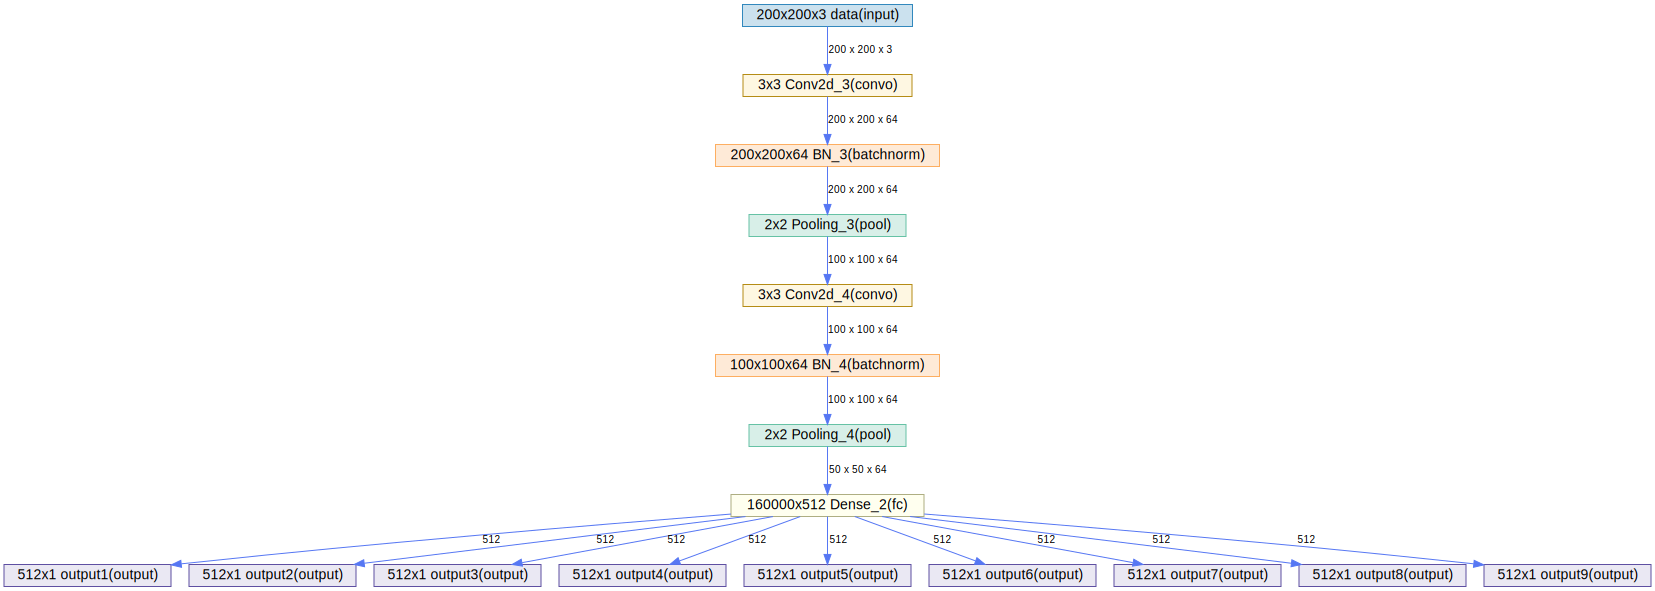

In [47]:
model.plot_network()

In [23]:
# View Last Added Layer for Check
conn.fetch(table=dict(name=model.model_name, where='_dllayerid_ = 16'))

,_DLKey0_,_DLKey1_,_DLChrVal_,_DLNumVal_,_DLLayerID_
0,output9,outputopts.truncfact,truncfact,0.0,16.0
1,output9,layertype,Output Layer,5.0,16.0
2,output9,outputopts.init,Xavier,1.0,16.0
3,output9,srclayers.0,dense_1,7.0,16.0
4,output9,outputopts.initbias,initbias,0.0,16.0
5,output9,outputopts.n,n,1.0,16.0
6,output9,outputopts.act,Logistic,2.0,16.0
7,output9,outputopts.noFullConnect,noFullConnect,0.0,16.0
8,output9,outputopts.no_bias,no_bias,0.0,16.0
9,output9,outputopts.error,Entropy,4.0,16.0


<div class="alert alert-warning">
<b>MODEL TRAINING</b>
</div>

In [24]:
# Setup Optimization
optimizer = dict(seed=13309,
                 algorithm=dict(method='momentum',
                                  clipgradmin=-1000,
                                  clipgradmax=1000,
                                  learningRatePolicy='step',
                                  gamma=0.1,
                                  stepSize=15,
                                  learningRate=0.001),
                 maxEpochs=60,
                 miniBatchSize=32,
                 regL2=0.0001, 
                 loglevel=2
                )


model_train = conn.dlTrain(table=dict(name='retail_data_final', where='_PartInd_=0.0'),
                           optimizer=optimizer,
                           modelWeights=dict(name='retail_modelweights', replace=True),
                           modelTable=model.model_name,
                           dataSpecs=[{'type':'IMAGE', 'layer':'data', 'data':'_image_'},
                                      {'type':'numericnominal', 'layer':'output1', 'data':'black'},
                                      {'type':'numericnominal', 'layer':'output2', 'data':'blue'},
                                      {'type':'numericnominal', 'layer':'output3', 'data':'red' },
                                      {'type':'numericnominal', 'layer':'output4', 'data':'jeans'},
                                      {'type':'numericnominal', 'layer':'output5', 'data':'dress'},
                                      {'type':'numericnominal', 'layer':'output6', 'data':'shirt'},
                                      {'type':'numericnominal', 'layer':'output7', 'data':'denim'},
                                      {'type':'numericnominal', 'layer':'output8', 'data':'cotton_blend'},
                                      {'type':'numericnominal', 'layer':'output9', 'data':'women'}
                                     ],
                           recordSeed=54124,
                           seed=1236,
                           nthreads=1,
                           gpu=True
                          )

NOTE: Using dlgrd007.unx.sas.com: 2 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 81963977.
NOTE:  The approximate memory cost is 1013.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       5.60 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Number of output layers (including regression and classification tasks) is   9.
NOTE:  Number of keypoints layers is   0.
NOTE:  Number of detection layers is   0.
NOTE:  Number of segmentation layers is   0.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Layer ID:   8 Name: output1 Type: Output Layer
NOTE:  Target variable: black
NOTE:  Layer ID:   9 Name: output2 Type: Output Layer
NOTE:  Target variable: blue
NOTE:  Layer ID:  1

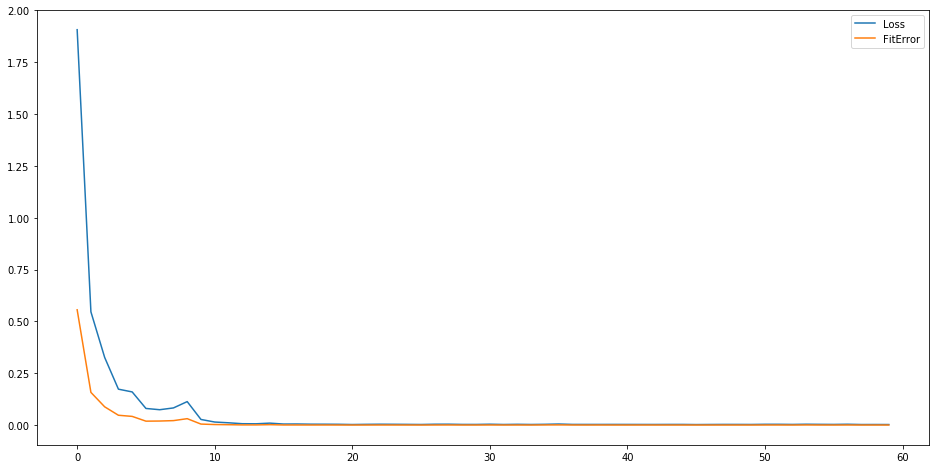

In [97]:
# View Train History
model_train.OptIterHistory[['Loss','FitError']].plot(figsize=(16,8));

<div class="alert alert-warning">
<b>MODEL SCORING AND RESULTS</b>
</div>

In [ ]:
# Score Test Data DLPy
model.set_weights('retail_modelweights')
model.predict(data=dict(name='retail_data_final', where= '_PartInd_=1.0')) 

In [27]:
# Score Test Data CAS Action
conn.dlScore(model = model.model_name,
             table = dict(name='retail_data_final', where= '_PartInd_=1.0'),
             initWeights = 'retail_modelweights', 
             copyVars = ['_id_','_size_','_type_','_path_','_image_','black','blue', \
                         'red','jeans','dress','shirt','denim','cotton_blend','women'],
             encodeName = True,
             casout = dict(name='scored_results', replace=True))

NOTE: Due to data distribution, miniBatchSize has been limited to 8.


,Descr,Value
0,Number of Observations Read,433
1,Number of Observations Used,433
2,"Mean Squared Error (output1, 8)",0.01005
3,"Mean Squared Error (output2, 9)",0.00996
4,"Mean Squared Error (output3, 10)",0.002153
5,"Mean Squared Error (output4, 11)",0.015752
6,"Mean Squared Error (output5, 12)",0.015749
7,"Mean Squared Error (output6, 13)",0.01662
8,"Mean Squared Error (output7, 14)",0.016477
9,"Mean Squared Error (output8, 15)",0.01624


In [28]:
# Get Results Table
res_table = conn.fetch(table='scored_results',
                       fetchVars=['_id_', 'black','blue','red','jeans','dress','shirt', \
                                  'denim','cotton_blend','women','P_black','P_blue','P_red', \
                                  'P_jeans','P_dress','P_shirt','P_denim','P_cotton_blend',
                                  'P_women'],
                       to=2165,
                       maxrows=2165)

In [29]:
# Results Table Shape
res_table['Fetch'].shape

(433, 19)

In [30]:
# Convert Results Table to Pandas Dataframe and Preview
res_table = pd.DataFrame(res_table['Fetch'])
res_table.head()

,_id_,black,blue,red,jeans,dress,shirt,denim,cotton_blend,women,P_black,P_blue,P_red,P_jeans,P_dress,P_shirt,P_denim,P_cotton_blend,P_women
0,490.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.444757e-10,1.000000,1.942235e-07,3.012753e-06,1.585583e-07,9.999989e-01,3.373810e-06,0.999998,3.228076e-07
1,166.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,8.657706e-10,0.000002,9.999995e-01,3.163024e-09,1.000000e+00,2.394765e-08,6.034829e-09,1.000000,1.000000e+00
2,1212.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.419905e-04,0.997409,2.703545e-03,1.373342e-02,9.955408e-01,2.583634e-06,6.403791e-03,0.996406,9.922792e-01
3,1261.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6.360966e-07,0.999999,4.258917e-06,6.442746e-05,9.995296e-01,2.275676e-04,1.238983e-04,0.999941,9.992799e-01
4,1223.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.918336e-06,0.999997,4.558038e-07,5.736664e-05,9.993350e-01,3.952158e-04,1.653436e-04,0.999824,9.991387e-01


In [31]:
# Set Probabilities to Binary Classification
res_table['pred_black'] = 0
res_table['pred_blue'] = 0
res_table['pred_red'] = 0
res_table['pred_jeans'] = 0
res_table['pred_dress'] = 0
res_table['pred_shirt'] = 0
res_table['pred_denim'] = 0
res_table['pred_cotton_blend'] = 0
res_table['pred_women'] = 0

res_table.loc[res_table['P_black'] >= 0.5, 'pred_black'] = 1
res_table.loc[res_table['P_blue'] >= 0.5, 'pred_blue'] = 1
res_table.loc[res_table['P_red'] >= 0.5, 'pred_red'] = 1
res_table.loc[res_table['P_jeans'] >= 0.5, 'pred_jeans'] = 1
res_table.loc[res_table['P_dress'] >= 0.5, 'pred_dress'] = 1
res_table.loc[res_table['P_shirt'] >= 0.5, 'pred_shirt'] = 1
res_table.loc[res_table['P_denim'] >= 0.5, 'pred_denim'] = 1
res_table.loc[res_table['P_cotton_blend'] >= 0.5, 'pred_cotton_blend'] = 1
res_table.loc[res_table['P_women'] >= 0.5, 'pred_women'] = 1

In [32]:
# Confusion Matrix of Test Data For Each Class
display(pd.crosstab(res_table['black'],res_table['pred_black']))
display(pd.crosstab(res_table['blue'],res_table['pred_blue']))
display(pd.crosstab(res_table['red'],res_table['pred_red']))
display(pd.crosstab(res_table['jeans'],res_table['pred_jeans']))
display(pd.crosstab(res_table['dress'],res_table['pred_dress']))
display(pd.crosstab(res_table['shirt'],res_table['pred_shirt']))
display(pd.crosstab(res_table['denim'],res_table['pred_denim']))
display(pd.crosstab(res_table['cotton_blend'],res_table['pred_cotton_blend']))
display(pd.crosstab(res_table['women'],res_table['pred_women']))

pred_black,0,1
black,,
0.0,373,3
1.0,1,56


pred_blue,0,1
blue,,
0.0,185,1
1.0,3,244


pred_red,0,1
red,,
0.0,304,0
1.0,1,128


pred_jeans,0,1
jeans,,
0.0,289,4
1.0,4,136


pred_dress,0,1
dress,,
0.0,275,5
1.0,4,149


pred_shirt,0,1
shirt,,
0.0,289,4
1.0,4,136


pred_denim,0,1
denim,,
0.0,289,4
1.0,4,136


pred_cotton_blend,0,1
cotton_blend,,
0.0,136,4
1.0,4,289


pred_women,0,1
women,,
0.0,276,4
1.0,4,149


## Save Model to ASTORE

In [33]:
# Save Out Final Data, Model Weights, and Scored Test Data
conn.save(table='retail_data_final', name="retail_data_final.sashdat", replace=True, caslib='retaildata')
conn.save(table='retail_modelweights', name="retail_modelweights.sashdat", replace=True, caslib='retaildata')
conn.save(table='scored_results', name="retail_scored_results.sashdat", replace=True, caslib='retaildata');

NOTE: Cloud Analytic Services saved the file retail_data_final.sashdat in caslib retaildata.
NOTE: Cloud Analytic Services saved the file retail_modelweights.sashdat in caslib retaildata.
NOTE: Cloud Analytic Services saved the file retail_scored_results.sashdat in caslib retaildata.


In [34]:
conn.dlExportModel(model=model.model_name, 
                       initWeights='retail_modelweights', 
                       casout=dict(name='retail_astore', replace=True))

NOTE: Wrote 327870202 bytes to the savestate file retail_astore.


,casLib,Name
0,retaildata,retail_astore


In [35]:
conn.dlExportModel(model=model.model_name, 
                       initWeights='retail_modelweights', 
                       casout=dict(name='retail_astore', replace=True))

retail_ast = conn.astore.download(rstore='retail_astore')

with open('U:\\astore\\retail_fnn.astore','wb') as file:
    file.write(retail_ast['blob'])



NOTE: Wrote 327870202 bytes to the savestate file retail_astore.


##  Score ASTORE

In [45]:
# Score ASTORE
with open('U:\\astore\\retail_fnn.astore', mode='rb') as file: 
    fileContent = file.read()
 
store_ = sw.blob(fileContent)
#conn.astore.upload(rstore='retail_fnn',store = store_)
conn.score(rstore = 'retail_fnn',
            copyVars = ['_id_','_size_','_type_','_path_','_image_','black','blue', \
                         'red','jeans','dress','shirt','denim','cotton_blend','women'],
        table = dict(name='retail_data_final'),
        out = dict(name='scoreastore_images', replace=True))


         
         

[OutputCasTables]

        casLib                Name  Rows  Columns  \
 0  retaildata  scoreastore_images  2165       23   
 
                                             casTable  
 0  CASTable('scoreastore_images', caslib='retaild...  

[Timing]

 Task Timing
 
                  Task    Seconds   Percent
 0   Loading the Store   0.000730  0.000031
 1  Creating the State   9.895819  0.422611
 2             Scoring  13.519352  0.577358
 3               Total  23.415904  1.000000

+ Elapsed: 23.5s, user: 688s, sys: 11.4s, mem: 6.31e+03mb

In [45]:
conn.endsession()

+ Elapsed: 0.000188s, sys: 0.000436s, mem: 0.194mb